In [321]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

######################## PART 1 #####################################################
def getTrainingData(insulin_csv, cgm_csv):
    insulin_columns_to_read = ['Date', 'Time', 'BWZ Carb Input (grams)']
    df_insulin = pd.read_csv(insulin_csv, usecols=insulin_columns_to_read)
    df_insulin['Date'] = pd.to_datetime(df_insulin['Date'], errors='coerce').dt.date
    df_insulin['Date'] = df_insulin['Date'].astype(str)
    df_insulin['datetime'] = pd.to_datetime(df_insulin['Date'] + ' ' + df_insulin['Time'], errors='coerce')
    df_insulin = df_insulin.drop(columns=['Date', 'Time'])
    df_insulin = df_insulin.rename(columns={'BWZ Carb Input (grams)': 'meal'})
    df_insulin = df_insulin.dropna(subset=['meal'])
    df_insulin = df_insulin[df_insulin['meal'] != 0]
    df_insulin = df_insulin.sort_values(by='datetime').reset_index(drop=True)

    del insulin_columns_to_read

    meal_time = []
    # Loop through the DataFrame to find meal times with a > 2-hour gap
    for i in range(len(df_insulin) - 1):
        current_time = df_insulin['datetime'].iloc[i]
        next_time = df_insulin['datetime'].iloc[i + 1]

        if current_time + pd.Timedelta(hours=2) < next_time:
            meal_time.append(current_time)

    cgm_columns_to_read = ['Date', 'Time', 'Sensor Glucose (mg/dL)']
    df_cgm = pd.read_csv(cgm_csv, usecols=cgm_columns_to_read)
    df_cgm = df_cgm.rename(columns={'Sensor Glucose (mg/dL)': 'glucose'})
    df_cgm['datetime'] = pd.to_datetime(df_cgm['Date'] + ' ' + df_cgm['Time'])
    df_cgm = df_cgm.drop(columns=['Date', 'Time'])
    df_cgm = df_cgm.sort_values(by='datetime').reset_index(drop=True)

    del cgm_columns_to_read

    # find datetime for Sugar Glucose Level based on meal time, ex(meal time = 9:00, SugarGlucose measured after meal = 9:03), make meal time = 9:03
    index = 0
    new_meal_time = []

    for i in range(len(df_cgm)):
        if (df_cgm['datetime'].iloc[i] > meal_time[index]):
            if (df_cgm['datetime'].iloc[i] < (meal_time[index] + pd.Timedelta(minutes=5))): # Edge case: meal time and glucose measure not with in 5 min
                new_meal_time.append(df_cgm['datetime'].iloc[i])

            if (index < len(meal_time) - 1):
                index += 1

    meal_time = new_meal_time

    del new_meal_time
    del index

    # locate meal_time and add glucose level 30 min before and 2hr after meal_time, 30 data per row including meal_time glucose level
    total_glucose_data = 30 # 2hrs:30min / 5min
    num_glucose_before_meal = 6 # 30min / 5min

    meal_data = []
    no_meal_time = []

    for datetime in  meal_time:
        data = []
        index = df_cgm[df_cgm['datetime'] == datetime].index[0] - num_glucose_before_meal

        for row in range(index, index + total_glucose_data + 1):
            if (row < index + total_glucose_data):
                data.append(df_cgm.loc[row, 'glucose'])
            else:
                no_meal_time.append(df_cgm.loc[row, 'datetime'])

        meal_data.append(data)

    del index
    del data

    column_names = [f'col{i+1}' for i in range(len(meal_data[0]))]
    meal_data = pd.DataFrame(meal_data, columns=column_names)
    #-----------------------------Meal data (ready)------------------------------------------------------

    # --------------------------- start no meal data ---------------------------------------------------
    no_meal_data = []
    new_no_meal_time = []

    # adding start time of post_absorptive period given there is no next meal inbetween two hours of post aborptive period
    for i in range(len(no_meal_time) - 1):
        post_absorptive_period_start = no_meal_time[i]
        post_absorptive_period_end = post_absorptive_period_start + pd.Timedelta(hours=2)

        if (post_absorptive_period_start <= meal_time[i+1] and meal_time[i+1] < post_absorptive_period_end):
            continue

        new_no_meal_time.append(post_absorptive_period_start)

    no_meal_time = new_no_meal_time

    del new_no_meal_time

    for datetime in  no_meal_time:
        data = []
        try:
            index = df_cgm[df_cgm['datetime'] == datetime].index[0]
        except:
            print(datetime, 'datetime not found')

        for row in range(index, index + (total_glucose_data - num_glucose_before_meal)):
            data.append(df_cgm.loc[row, 'glucose'])

        no_meal_data.append(data)

    column_names = [f'col{i+1}' for i in range(len(no_meal_data[0]))]
    no_meal_data = pd.DataFrame(no_meal_data, columns=column_names)

    return meal_data, no_meal_data

meal_data, no_meal_data = getTrainingData('InsulinData.csv', 'CGMData.csv')
meal_data_1, no_meal_data_1 = getTrainingData('Insulin_patient2.csv', 'CGM_patient2.csv')

meal_data = pd.concat([meal_data, meal_data_1], axis=0, ignore_index=True)
no_meal_data = pd.concat([no_meal_data, no_meal_data_1], axis=0, ignore_index=True)

del meal_data_1
del no_meal_data_1

meal_data.reset_index(drop=True, inplace=True)
no_meal_data.reset_index(drop=True, inplace=True)

# Handling Missing data
# 1. Get rid of rows thats mising more that 5% of the data
def rid_rows_threshold(record):
    threshold = 0.05 # 5%
    empty_cell_count = record.isna().sum(axis=1)
    total_cells = record.shape[1]
    rows_to_keep = empty_cell_count / total_cells < threshold
    return record[rows_to_keep]

meal_data = rid_rows_threshold(meal_data)
no_meal_data = rid_rows_threshold(no_meal_data)

# performing knn for 1st column is a bad idea because knn = 2
meal_data = meal_data.dropna(subset=['col1'])
no_meal_data = no_meal_data.dropna(subset=['col1'])

# 2. perform KNN to predict missing values
def knn_imputer(record):
    imputer = KNNImputer(n_neighbors=2)

    return pd.DataFrame(imputer.fit_transform(record), columns=record.columns)

meal_data = knn_imputer(meal_data)
no_meal_data = knn_imputer(no_meal_data)
print(len(meal_data))
print(len(no_meal_data))

663
529


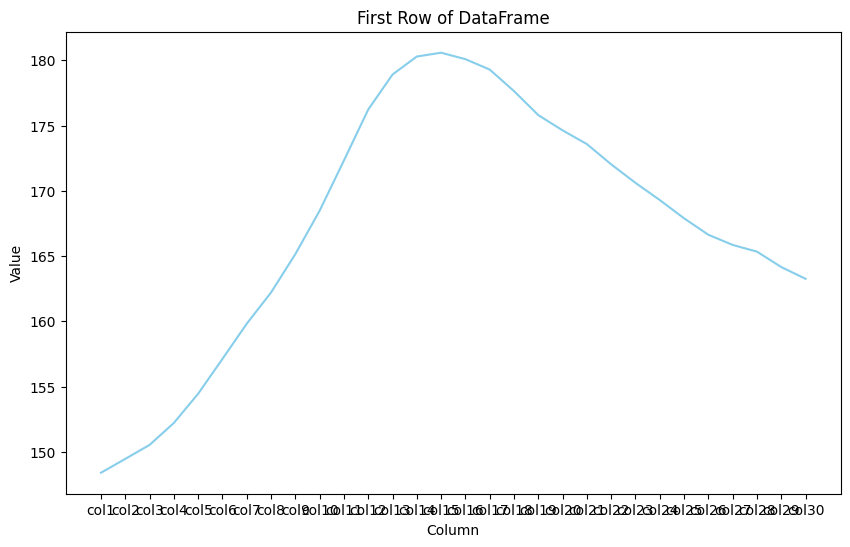

In [322]:
row = meal_data.mean()
# Create a plot
plt.figure(figsize=(10, 6))

# Plot the first row
plt.plot(row.index, row.values, color='skyblue')

# Add title and labels
plt.title('First Row of DataFrame')
plt.xlabel('Column')
plt.ylabel('Value')

# Display the plot
plt.show()

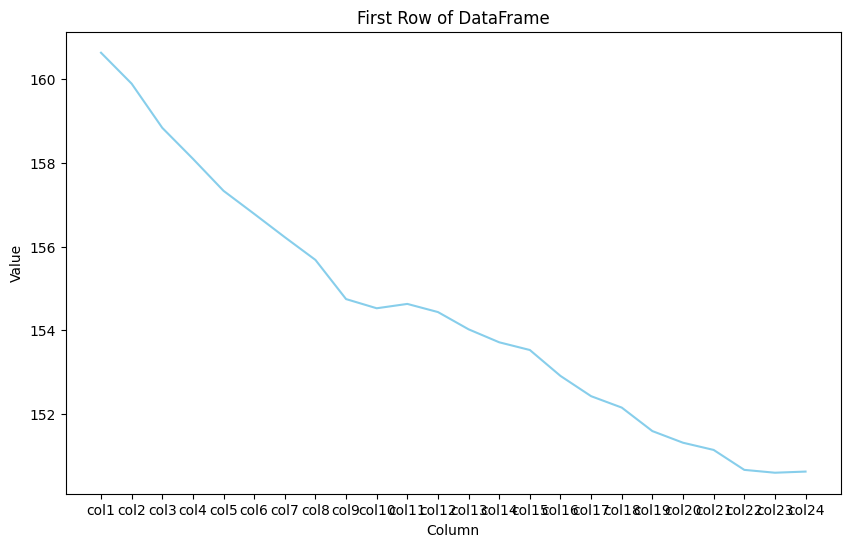

In [323]:
row = no_meal_data.mean()
# Create a plot
plt.figure(figsize=(10, 6))

# Plot the first row
plt.plot(row.index, row.values, color='skyblue')

# Add title and labels
plt.title('First Row of DataFrame')
plt.xlabel('Column')
plt.ylabel('Value')

# Display the plot
plt.show()

In [324]:
# ---------------------------- Step 2 --------------------------------
########################## Feature Extraction and Selection ######################

# 1. Time difference between peak after meal
def time_difference(record, start_index):
    filtered_record = record.iloc[:, start_index:]
    max_indices = filtered_record.idxmax(axis=1)
    column_positions = max_indices.map(lambda col: record.columns.get_loc(col))
    result = (column_positions - start_index) * 5
    return pd.DataFrame(result, columns=['time difference'])

time_difference_meal = time_difference(meal_data, 5)
time_difference_no_meal = time_difference(no_meal_data, 0)

In [325]:
# feature 2: glucose level difference after the meal (max glucose level - min glucose level)
def glucose_level_difference(record, start_index):
    max_indices = record.max(axis=1)
    meal_indices = record.iloc[:, start_index]
    result = (max_indices - meal_indices) / meal_indices
    return pd.DataFrame(result, columns=['glucose level difference'])

glucose_level_difference_meal = glucose_level_difference(meal_data, 5)
glucose_level_difference_no_meal = glucose_level_difference(no_meal_data, 0)

In [326]:
# Decision Tree
def decisionTree(record):
    X = record.drop('target', axis=1)
    y = record['target']

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    tree = DecisionTreeClassifier()

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        tree.fit(X_train, y_train)

        y_pred = tree.predict(X_test)

        precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
        accuracies.append(accuracy_score(y_test, y_pred))

    print(f'Average Accuracy: {np.mean(accuracies):.2f}')
    print(f'Average Precision: {np.mean(precisions):.2f}')
    print(f'Average Recall: {np.mean(recalls):.2f}')
    print(f'Average F1 Score: {np.mean(f1_scores):.2f}')

In [327]:
# Feature 1: time difference
time_difference_meal['target'] = 1
time_difference_no_meal['target'] = 0

time_difference_data = pd.concat([time_difference_meal, time_difference_no_meal], axis=0)
decisionTree(time_difference_data)

Average Accuracy: 0.72
Average Precision: 0.72
Average Recall: 0.72
Average F1 Score: 0.72


In [328]:
# feature 2: glucose level difference
glucose_level_difference_meal['target'] = 1
glucose_level_difference_no_meal['target'] = 0

glucose_level_difference_data = pd.concat([glucose_level_difference_meal, glucose_level_difference_no_meal])
decisionTree(glucose_level_difference_data)

Average Accuracy: 0.52
Average Precision: 0.54
Average Recall: 0.52
Average F1 Score: 0.53


In [329]:
# testing on test data
final_data = time_difference_data
